In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import random
import cv2

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, label_binarize
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

from pathlib import Path

/usr/lib/python3/dist-packages/pytz/__init__.py:31: SyntaxWarning: invalid escape sequence '\s'
  match = re.match("^#\s*version\s*([0-9a-z]*)\s*$", line)


### PATHS

In [2]:
PROJ_ROOT = Path().resolve().parents[0]

DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
EXTERNAL_DATA_DIR = DATA_DIR / "external"

MODELS_DIR = PROJ_ROOT / "models/tmp"

In [3]:
input_path: Path = RAW_DATA_DIR / "cifar-10-batches-py"
data_path: Path = EXTERNAL_DATA_DIR / "processed_dataset.pkl"
predictions_path: Path = EXTERNAL_DATA_DIR / "test_predictions.csv"
model_path: Path = MODELS_DIR

### FEATURES AND DATA PROCESSING

In [4]:
def load_data(file_path, encoding=None):
    """
    Load data from a pickle file

    Args:
        file_path: str
    """
    with open(file_path, 'rb') as f:
        if (encoding is not None):
            data = pickle.load(f, encoding=encoding)
        else:
            data = pickle.load(f)
    return data

def save_data(data, file):
    """
    Save data to a pickle file

    Args:
        data: any
        file: str
    """
    with open(file, 'wb') as f:
        pickle.dump(data, f)

def to_image(img_flat):
    """
    Convert a flattened image to a 3D image

    Args:
        img_flat: np.ndarray
    """
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))
    return img

def contrast_images(images):
    """
    Compute the contrast of all images

    Args:
        images: np.ndarray
    """
    enhanced_images = []
    for image in images:
        enhanced_images.append(contrast(image))

    return np.array(enhanced_images)

def contrast(image):
    """
    Compute the contrast of an image

    Args:
        image: (32, 32, 3) shape image
    """
    image = image.astype(np.uint8)
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    return enhanced_img

### Image Flattener

In [5]:
class ImageFlattener(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        x = X.reshape(X.shape[0], -1)
        return x

### VLAD

In [6]:
from random import sample

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import progressbar as pb


class VLAD:
    """VLAD - Vector of Locally Aggregated Descriptors

    This class provides an implementation of the original proposal of "Vector of Locally Aggregated Descriptors" (VLAD)
    originally proposed in [1]_.

    Parameters
    ----------
    k : int, default=256
        Number of clusters to obtain for the visual vocabulary.
    n_vocabs : int, default=1
        Number of vocabularies to use
    norming : {"original", "intra", "RN"}, default="original"
        How the norming of the VLAD-descriptors should be performed.
        For more info see below.
    lcs : bool, default=True
        If `True`, uses Local Coordinate System (LCS) described in [3]_.
    alpha : float, default=0.2
        The exponent for the root-part, default taken from [3]_
    verbose : bool, default=True
        If `True` print messages here and there

    Attributes
    ----------
    vocabs : sklearn.cluster.KMeans(k)
        The visual vocabulary of the object
    centers : array
        The centroids for the visual vocabulary
    database : array
        All known VLAD-vectors

    Notes
    -----
    ``norming="original"`` uses the original formulation of [1]_. An updated formulation based on [2]_
    is provided by ``norming="intra"``. Finally the best norming based on [3]_ is provided by ``norming="RN"``.

    References
    ----------
    .. [1] Jégou, H., Douze, M., Schmid, C., & Pérez, P. (2010, June). Aggregating
           local descriptors into a compact image representation. In 2010 IEEE computer
           society conference on computer vision and pattern recognition (pp. 3304-3311). IEEE.

    .. [2] Arandjelovic, R., & Zisserman, A. (2013). All about VLAD. In Proceedings of the
           IEEE conference on Computer Vision and Pattern Recognition (pp. 1578-1585).

    .. [3] Delhumeau, J., Gosselin, P. H., Jégou, H., & Pérez, P. (2013, October).
           Revisiting the VLAD image representation. In Proceedings of the 21st ACM
           international conference on Multimedia (pp. 653-656).

    .. [4] Jégou, H., & Chum, O. (2012, October). Negative evidences and co-occurences in image
           retrieval: The benefit of PCA and whitening. In European conference on computer vision
           (pp. 774-787). Springer, Berlin, Heidelberg.

    .. [5] Spyromitros-Xioufis, E., Papadopoulos, S., Kompatsiaris, I. Y., Tsoumakas, G., & Vlahavas,
           I. (2014). A comprehensive study over VLAD and product quantization in large-scale image retrieval.
           IEEE Transactions on Multimedia, 16(6), 1713-1728.
    """
    def __init__(self, k=256, n_vocabs=1, norming="original", lcs=False, alpha=0.2, verbose=True):
        """Initialize VLAD-object

        Notes
        -----

        Hyperparameters have to be set, even if `centers` and `qs` are set externally.
        """
        self.k = k
        self.n_vocabs = n_vocabs
        self.norming = norming
        self.vocabs = None
        self.centers = None
        self.database = None
        self.lcs = lcs
        self.alpha = alpha
        self.qs = None
        self.verbose = verbose

    def fit(self, X, y):
        """Fit Visual Vocabulary

        Parameters
        ----------
        X : list(array)
            List of image descriptors

        Returns
        -------
        self : VLAD
            Fitted object
        """
        X_mat = np.vstack(X)
        self.vocabs = []
        self.centers = []  # Is a list of `n_vocabs` np.arrays. Can be set externally without fitting
        self.qs = []  # Is a list of `n_vocabs` lists of length `k` of np.arrays. Can be set externally without fitting
        for i in range(self.n_vocabs):
            if self.verbose is True:
                print(f"Training vocab #{i+1}")
            if self.verbose is True:
                print(f"Training KMeans...")
            if len(X_mat) < int(2e5):
                self.vocabs.append(KMeans(n_clusters=self.k).fit(X_mat))
            else:
                idx = sample(range(len(X_mat)), int(2e5))
                self.vocabs.append(KMeans(n_clusters=self.k).fit(X_mat[idx]))
            self.centers.append(self.vocabs[i].cluster_centers_)
            if self.lcs is True and self.norming == "RN":
                if self.verbose is True:
                    print("Finding rotation-matrices...")
                predicted = self.vocabs[i].predict(X_mat)
                qsi = []
                for j in range(self.k):
                    q = PCA(n_components=X_mat.shape[1]).fit(X_mat[predicted == j]).components_
                    qsi.append(q)
                self.qs.append(qsi)
        self.database = self._extract_vlads(X)
        return self

    def transform(self, X):
        """Transform the input-tensor to a matrix of VLAD-descriptors

        Parameters
        ----------
        X : list(array)
            List of image-descriptors

        Returns
        -------
        vlads : array, shape (n, d * self.k)
            The transformed VLAD-descriptors
        """
        vlads = self._extract_vlads(X)
        return vlads

    def fit_transform(self, X, y):
        """Fit the model and transform the input-data subsequently

        Parameters
        ----------
        X : list(array)
            List of image-descriptors

        Returns
        -------
        vlads : array, shape (n, d * self.k)
            The transformed VLAD-descriptors
        """
        _ = self.fit(X, y)
        vlads = self.transform(X)
        return vlads

    def refit(self, X):
        """Refit the Visual Vocabulary

        Uses the already learned cluster-centers as in initial values for
        the KMeans-models

        Parameters
        ----------
        X : array
            The database used to refit the visual vocabulary

        Returns
        -------
        self : VLAD
            Refitted object
        """
        self.vocabs = []
        self.centers = []

        for i in range(self.n_vocabs):
            self.vocabs.append(KMeans(n_clusters=self.k, init=self.centers).fit(X.transpose((2, 0, 1))
                                                                                .reshape(-1, X.shape[1])))
            self.centers.append(self.vocabs[i].cluster_centers_)

        self.database = self._extract_vlads(X)
        return self

    def predict(self, desc):
        """Predict class of given descriptor-matrix

        Parameters
        ----------
        desc : array
            A descriptor-matrix (m x d)

        Returns
        -------
        ``argmax(self.predict_proba(desc))`` : array
        """
        return np.argmax(self.predict_proba(desc))

    def predict_proba(self, desc):
        """Predict class of given descriptor-matrix, return probability

        Parameters
        ----------
        desc : array
            A descriptor-matrix (m x d)

        Returns
        -------
        ``self.database @ vlad``
            The similarity for all database-classes
        """
        vlad = self._vlad(desc)  # Convert to VLAD-descriptor
        return self.database @ vlad  # Similarity between L2-normed vectors is defined as dot-product

    def _vlad(self, X):
        """Construct the actual VLAD-descriptor from a matrix of local descriptors

        Parameters
        ----------
        X : array
            Descriptor-matrix for a given image

        Returns
        -------
        ``V.flatten()`` : array
            The VLAD-descriptor
        """
        np.seterr(invalid='ignore', divide='ignore')  # Division with 0 encountered below
        vlads = []

        for j in range(self.n_vocabs):  # Compute for multiple vocabs
            # predicted = self.vocabs[j].predict(X)  # Commented out in favor of line below (No dependency on actual vocab, but only on centroids)
            predicted = norm(X - self.centers[j][:, None, :], axis=-1).argmin(axis=0)
            _, d = X.shape
            V = np.zeros((self.k, d))  # Initialize VLAD-Matrix

            # Computing residuals
            if self.norming == "RN":
                curr = X - self.centers[j][predicted]
                curr /= norm(curr, axis=1)[:, None]
                # Untenstehendes kann noch vektorisiert werden

                for i in range(self.k):
                    V[i] = np.sum(curr[predicted == i], axis=0)
                    if self.lcs is True:
                        V[i] = self.qs[j][i] @ V[i]  # Equivalent to multiplication in  summation above
            else:
                for i in range(self.k):
                    V[i] = np.sum(X[predicted == i] - self.centers[j][i], axis=0)

            # Norming
            if self.norming in ("intra", "RN"):
                V /= norm(V, axis=1)[:, None]  # L2-normalize every sum of residuals
                np.nan_to_num(V, copy=False)  # Some of the rows contain 0s. np.nan will be inserted when dividing by 0!

            if self.norming in ("original", "RN"):
                V = self._power_law_norm(V)

            V /= norm(V)  # Last L2-norming
            V = V.flatten()
            vlads.append(V)
        vlads = np.concatenate(vlads)
        vlads /= norm(vlads)  # Not on axis, because already flat
        return vlads

    def _extract_vlads(self, X):
        """Extract VLAD-descriptors for a number of images

        Parameters
        ----------
        X : list(array)
            List of image-descriptors

        Returns
        -------
        database : array
            Database of all VLAD-descriptors for the given Tensor
        """
        vlads = []
        if self.verbose:
            for x in pb.progressbar(X):
                vlads.append(self._vlad(x))
        else:
            for x in X:
                vlads.append(self._vlad(x))

        database = np.vstack(vlads)
        return database

    def _add_to_database(self, vlad):
        """Add a given VLAD-descriptor to the database

        Parameters
        ----------
        vlad : array
            The VLAD-descriptor that should be added to the database

        Returns
        -------
        ``None``
        """
        self.database = np.vstack((self.database, vlad))

    def _power_law_norm(self, X):
        """Perform power-Normalization on a given array

        Parameters
        ----------
        X : array
            Array that should be normalized

        Returns
        -------
        normed : array
            Power-normalized array
        """
        normed = np.sign(X) * np.abs(X)**self.alpha
        return normed

    def __repr__(self):
        return f"VLAD(k={self.k}, norming=\"{self.norming}\")"

    def __str__(self):
        return f"VLAD(k={self.k}, norming=\"{self.norming}\")"

### METHODS FOR MODELS LOADING & SAVING

In [7]:
def save_model(model, model_name, model_dir='models'):
    """
    Save the trained model to a file.
    
    Args:
        model: Trained model to be saved.
        model_name: The name of the model file.
        model_dir: Directory where the model will be saved.
    """
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    file_path = os.path.join(model_dir, model_name)
    joblib.dump(model, file_path)
    print(f"Model saved to {file_path}")

def load_model(model_name, model_dir='models'):
    """
    Load a trained model from a file.
    
    Args:
        model_name: The name of the model file.
        model_dir: Directory where the model is saved.
    
    Returns:
        Loaded model.
    """
    file_path = os.path.join(model_dir, model_name)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No model found at {file_path}")
    
    model = joblib.load(file_path)
    print(f"Model loaded from {file_path}")
    return model

### DATASET

In [8]:
print("Processing dataset...")
meta_dict = load_data(input_path / "batches.meta", encoding='bytes')
label_names = meta_dict[b'label_names']
print(f"Labels/Features: {label_names}")

combined_dict = {
    b'data': [],
    b'labels': [],
    b'label_names': label_names,
    b'hog_data': [],
    b'validation_data': [],
    b'validation_labels': [],
    b'validation_hog_data': [],
    b'test_data': [],
    b'test_labels': [],
    b'test_hog_data': [],
    b'sample_images': {label: [] for label in label_names}
}

for i in range(5):
    batch_dict = load_data(input_path / f"data_batch_{i+1}", encoding='bytes')
    combined_dict[b'data'].extend(batch_dict[b'data'])
    combined_dict[b'labels'].extend(batch_dict[b'labels'])

# Diviser les données en données d'entraînement et de validation
combined_dict[b'data'], combined_dict[b'validation_data'], combined_dict[b'labels'], combined_dict[b'validation_labels'] = train_test_split(
    combined_dict[b'data'], combined_dict[b'labels'], test_size=0.2, random_state=42
)

# Charger les données de test depuis test_batch
test_batch_dict = load_data(input_path / "test_batch", encoding='bytes')
combined_dict[b'test_data'].extend(test_batch_dict[b'data'])
combined_dict[b'test_labels'].extend(test_batch_dict[b'labels'])

# Sélectionner 10 images aléatoires pour chaque classe
for label_index, label in enumerate(label_names):
    label_indices = [i for i, lbl in enumerate(combined_dict[b'labels']) if lbl == label_index]
    sample_indices = random.sample(label_indices, 10)
    for idx in sample_indices:
        combined_dict[b'sample_images'][label].append(combined_dict[b'data'][idx])

save_data(combined_dict, data_path)

Processing dataset...
Labels/Features: [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


### DATA DICTIONARY KEYS

In [9]:
combined_dict.keys()

dict_keys([b'data', b'labels', b'label_names', b'hog_data', b'validation_data', b'validation_labels', b'validation_hog_data', b'test_data', b'test_labels', b'test_hog_data', b'sample_images'])

### MODELS

In [10]:
models = {
    'random_forest': RandomForestClassifier(random_state=42, criterion='entropy', max_depth=10), # criterion, max_depth
    'svm': SVC(max_iter=100 , kernel='rbf', random_state=42), # degree, gamma
    'logistic_regression': LogisticRegression(random_state=42), # penalty, solver
    'knn': KNeighborsClassifier(), # n_neighbors, algorithm
    # 'gradient_boosting': GradientBoostingClassifier(learning_rate=0.01, random_state=42) # loss, max_depth, criterion
}

### PIPELINE

In [11]:
pipeline = Pipeline([
    # ('contrast', FunctionTransformer(contrast_images, validate=False)),
    # ('grayscale', FunctionTransformer(rgb2gray, validate=False)),
    ('flatten', ImageFlattener()),
    # ('scaler', StandardScaler()),
    # ('sift_extraction', FunctionTransformer(extract_sift_features, validate=False)),
    # ('hog_extraction', FunctionTransformer(extract_hog_features, validate=False)),
    # ('vlad', VLAD(k=16, norming="RN", verbose=False)),
    # ('pca', PCA(n_components=2)),
    ('classifier', None)
])

### TRAINING & EVALUATING

In [12]:
data = load_data(data_path)

In [13]:
X_train = np.array(data[b'data']).reshape(-1, 32, 32, 3) / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)
y_train = np.array(data[b'labels'])
X_train = np.array([to_image(img) for img in X_train])


train_dict = {
    b'data': X_train,
    b'labels': y_train,
}
save_data(train_dict, EXTERNAL_DATA_DIR / "train_data.pkl")

X_validation = np.array(data[b'validation_data']).reshape(-1, 32, 32, 3) / 255.0
X_validation = X_validation.reshape(X_validation.shape[0], -1)
y_validation = np.array(data[b'validation_labels'])
X_validation = np.array([to_image(img) for img in X_validation])


validation_dict = {
    b'data': X_validation,
    b'labels': y_validation,
}
save_data(validation_dict, EXTERNAL_DATA_DIR / "validation_data.pkl")

In [14]:
# Train the models
for name, model in models.items():
    print(f"Training {name} model...")
    pipeline.set_params(classifier=model)

    pipeline.fit(X_train, y_train)
    print(f"{name} model trained.")

    y_pred = pipeline.predict(X_validation)

    accuracy = accuracy_score(y_validation, y_pred)
    print(f"{name} model accuracy: {accuracy:.2f}")

    save_model(model, f"{name}_model.pkl", model_path)
    print(f"{name} model saved.")

Training random_forest model...
random_forest model trained.
random_forest model accuracy: 0.41
Model saved to /mnt/d/Epita/MLRF/cifar_mlrf/models/tmp/random_forest_model.pkl
random_forest model saved.
Training svm model...


### TESTING

In [ ]:
X_test = np.array(data[b'test_data']).reshape(-1, 32, 32, 3) / 255.0
X_test = X_test.reshape(X_test.shape[0], -1)
X_test_2d = X_test
y_test = np.array(data[b'test_labels'])
X_test = np.array([to_image(img) for img in X_test])

test_dict = {
    b'data': X_test,
    b'labels': y_test,
}
save_data(test_dict, EXTERNAL_DATA_DIR / "test_data.pkl")

predictions = {'True Labels': y_test}

In [ ]:
# Evaluate the models
for name, _ in models.items():
    model = load_model(f'{name}_model.pkl', model_path)
    print(f"Evaluating {name} model...")

    pipeline.set_params(classifier=model)

    y_pred = pipeline.predict(X_test)
    predictions[name] = y_pred

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} model accuracy: {accuracy:.2f}")
    
    scores = cross_val_score(model, X_test_2d, y_test, cv=5)
    print(f"{name} model cross-validation accuracy: {scores.mean():.2f}")

predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv(predictions_path, index=False)
print(f"Predictions saved to {predictions_path}")

Model loaded from /mnt/d/Epita/MLRF/cifar_mlrf/models/tmp/random_forest_model.pkl
Evaluating random_forest model...
random_forest model accuracy: 0.42
random_forest model cross-validation accuracy: 0.40
Model loaded from /mnt/d/Epita/MLRF/cifar_mlrf/models/tmp/svm_model.pkl
Evaluating svm model...
svm model accuracy: 0.24


/home/nicolas/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nicolas/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nicolas/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nicolas/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/nicolas/.local/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solv

svm model cross-validation accuracy: 0.33
Model loaded from /mnt/d/Epita/MLRF/cifar_mlrf/models/tmp/logistic_regression_model.pkl
Evaluating logistic_regression model...
logistic_regression model accuracy: 0.40


/home/nicolas/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nicolas/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

logistic_regression model cross-validation accuracy: 0.37
Model loaded from /mnt/d/Epita/MLRF/cifar_mlrf/models/tmp/knn_model.pkl
Evaluating knn model...
knn model accuracy: 0.33
knn model cross-validation accuracy: 0.29
Predictions saved to /mnt/d/Epita/MLRF/cifar_mlrf/data/external/test_predictions.csv


### GRAPH PLOTS

#### Correlations, Matrices de Confusion, Courbe Precision-Recall, Courbes ROC

In [ ]:
predictions_df = pd.read_csv(predictions_path)
label_names = [label.decode('utf-8') for label in data[b'label_names']]

train_data = load_data(EXTERNAL_DATA_DIR / "train_data.pkl")
validation_data = load_data(EXTERNAL_DATA_DIR / "validation_data.pkl")
test_data = load_data(EXTERNAL_DATA_DIR / "test_data.pkl")

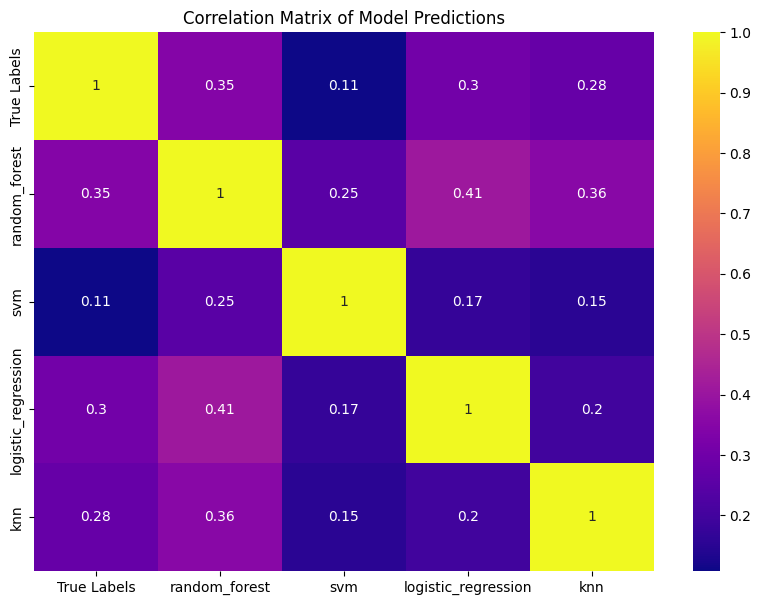

Plotting evaluation metrics for random_forest...


ValueError: Found input variables with inconsistent numbers of samples: [16000, 10000]

In [ ]:
# Correlation des prédictions
correlation_matrix = predictions_df.corr()
plt.figure(figsize=(10, 7))
plt.title('Correlation Matrix of Model Predictions')
sns.heatmap(correlation_matrix, annot=True, cmap='plasma')
plt.savefig("../reports/examples/correlation_matrix.png", bbox_inches='tight')
plt.show()

n_classes = len(label_names)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Matrice de confusion
for name, _ in models.items():
    print("=============================================================")
    print(f"Plotting evaluation metrics for {name}...")
    predictions = predictions_df[name]
    cmat = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(10, 7))
    plt.title(f'Confusion Matrix for {name}')
    plt.xticks(rotation=45)
    sns.heatmap(cmat, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f"../reports/examples/{name}/confusion_matrix.png", bbox_inches='tight')
    plt.show()

    # Courbes de précision/rappel et ROC
    preds_bin = label_binarize(predictions, classes=np.arange(n_classes))
    
    # Precision-Recall curve
    plt.figure()
    for i, label in enumerate(label_names):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], preds_bin[:, i])
        plt.plot(recall, precision, lw=2, label=f'{label}')
    plt.xticks(rotation=45)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall curve for {name}')
    plt.legend(loc='best')
    plt.savefig(f"../reports/examples/{name}/precis_recall_curve.png", bbox_inches='tight')
    plt.show()
    
    # ROC curve
    plt.figure()
    for i, label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], preds_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xticks(rotation=45)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {name}')
    plt.legend(loc='best')
    plt.savefig(f"../reports/examples/{name}/roc_curve.png", bbox_inches='tight')
    plt.show()